# 0. 오늘은 Regression 문제를 풀어 볼 예정입니다.

 - 오늘의 목표는 sin 함수를 예측해보는 LSTM 모델을 만드는 것입니다. 
 

In [1]:
import torch

tensor1 = torch.randn(16, 1, 5)  # shape: (16, 3, 3)
tensor2 = torch.randn(16, 5, 16)   # shape: (3, 4, 5)

result = torch.matmul(tensor1, tensor2)
print(result.size())

torch.Size([16, 1, 16])


## 1.우선 필요 라이브러리를 import 합니다.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch.utils import data

import torch.optim as optim


## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1  Device: cpu


# 3.모델 만들기


아래의 모델에서 many-to-many LSTM (맨 오른쪽) 모델을 만들어봅시다.

 - LSTM의 Hidden Unit의 수는 16으로 하세요
 
 - LSTM의 입력의 크기는 5개입니다. 즉, 5개의 입력값으로 5개의 출력값을 예측해 봅시다.
 

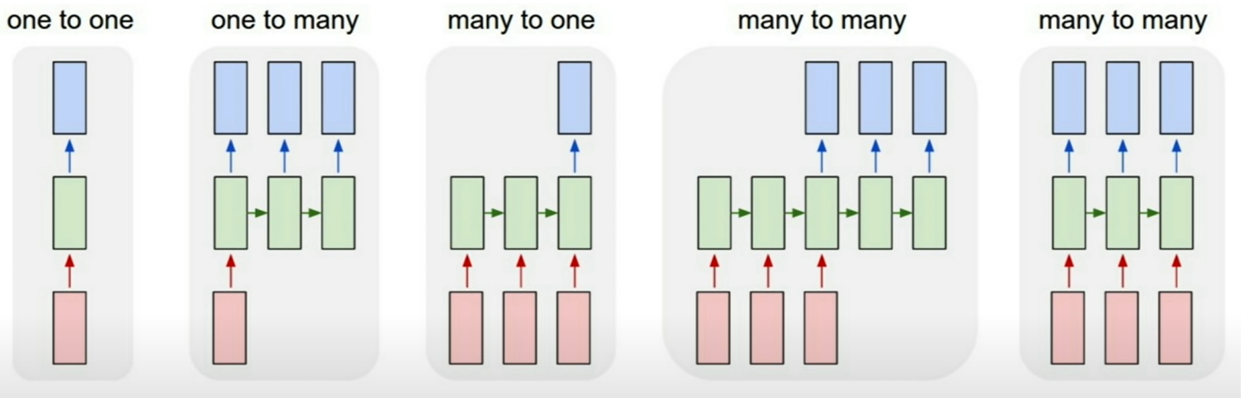

In [4]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()    
        self.lstm =  nn.LSTM(input_size=5,hidden_size=16,num_layers=1,batch_first = True)
        self.fc = nn.Linear(16, 1)

    def forward(self,x,h_state):
       
        x = x.transpose(1,2)
        #print(h_state[0])
        
        r_out, h_state = self.lstm(x, h_state)
        out = self.fc(r_out)
        print(out.shape)

        return out.squeeze()

# 3. Data를 만들어 봅시다

 - 입력값은 SIN 함수의 일부인 연속된 5개 값입니다.
 
 - many-to-many LSTM 모델은 5개의 SIN함수의 일부를 입력받아서 다음 번 숫자 5개를 예측합니다.
 
 - T는 1주기를 몇개의 값으로 표현했는지는 나타냅니다. 
 
 - n은 몇번의 주기를 만들지 표현합니다.
 
 - amp 는 sin함수의 크기를 나타냅니다.
 
 - alpha 는 시작점의 위치를 나타냅니다.
 

In [5]:
def sin_data(x, T=100):
    return np.sin(2.0*np.pi*x/T)

def toy_problem(n = 3, T=100, amp = 3, alpha = 0):
    x = np.arange(0, n*T + 1) + alpha
    return amp*sin_data(x, T)


 - sin_dataset: 새로운 데이터를 모델에 입력하기 위해 Dataset를 정의합니다. 
 
 - prepare_data: 입력은 n, T, alpha를 받습니다. 출력은 sin 함수의 연속된 값을 5개씩으로 데이터를 만들고 이에 대한 label을 sin함수의 6번째 값으로 지정합니다. 

In [6]:
class sin_dataset(data.Dataset):
    def __init__(self, r_data, label):
        self.r_data = r_data.unsqueeze(-1)
        self.label = label
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,index):
        return self.r_data[index], self.label[index] 

def prepare_data(n,T, alpha=0):
    target = toy_problem(n=n, T=T, amp=3, alpha=0)
    plt.plot(target)
    plt.show()
    
    rd = []
    labels = []
    
    for i in range(T*n - 5):
        rd.append(target[i:i+5])
        labels.append(target[i+5])
    
    return torch.Tensor(rd), torch.Tensor(labels)


- train, validation, test 데이터셋을 만들고 이를 DataLoader에 입력합니다. 

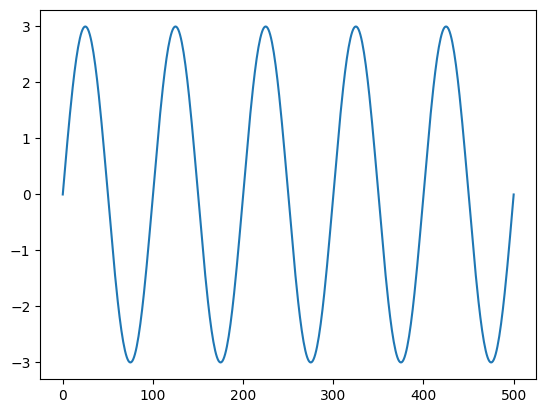

/Users/ohbeomseok/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473783/work/torch/csrc/utils/tensor_new.cpp:233.)


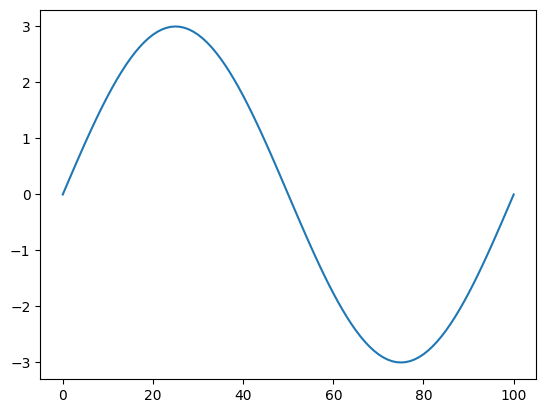

In [7]:
BATCH_SIZE = 16
T = 100
n = 5

pre_train = prepare_data(n,T)
pre_test = prepare_data(int(n/4),T,n+1)

train = sin_dataset(pre_train[0], pre_train[1])
test = sin_dataset(pre_test[0], pre_test[1])


train, val = data.random_split(train,[int(T*n*0.7),len(train)-int(T*n*0.7)])

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False)


## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) Test와 Validation data의 정확도 계산할 수 있는 함수 만들기

In [8]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 300
    
    for batch_idx, (r_data, label) in enumerate(train_loader):
        r_data, label = r_data.to(device), label.to(device)
        print(r_data.size(),label.size())
        # 미분값의 초기화
        optimizer.zero_grad()
        # Forward propagration 계산하기.
        init_h = torch.zeros(1,r_data.size(0),16)
        c_0 = torch.zeros(1,r_data.size(0),16)

        outputs = network(r_data,(init_h,c_0))
        
        # MSE 함수를 적용하여 loss를 구하고 저장하기
        
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses

In [9]:
def test_epoch(test_loader, network, loss_func, val = False):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)

            # Forward propagration 계산하기.
            init_h = torch.zeros(1,image.size(0),16)
            c_0 = torch.zeros(1, image.size(0),16)

            outputs = network(image,(init_h,c_0))
            
            # MSE 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())


        #중간결과 출력
        if val is True:
            print('Validation set: Loss: {:.5f}\n'.format(loss))
        
        else:
            print('Test set: Loss: {:.5f}\n'.format(loss))
        
    return test_losses


## 8. 위 정의된 함수로 학습 함수 만들기

- Adam Optimizer를 사용하여 학습시키기

- MSELoss() 함수를 사용할 것

In [10]:
def training(network, learning_rate = 0.001):
    
    epoches = 200
    
    cls_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
  
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Loss {:.6f}'.format(average_loss))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses = test_epoch(train_loader, network, cls_loss, True)

        test_losses_per_epoch.append(np.mean(test_losses))
        
    with torch.no_grad():
        test_losses = test_epoch(test_loader, network, cls_loss, False)
        
    return train_losses_per_epoch, test_losses_per_epoch


In [11]:
model = LSTM().to(device) # 채우시오#채우시오
train_loss, test_loss = training(model)#채우시오

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 0 [0/350 (0.00%)]	Loss: 4.896711
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Siz

torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.333891
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.21482

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 15 [0/350 (0.00%)]	Loss: 0.420964
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Siz

torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.15540

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 19 [0/350 (0.00%)]	Loss: 0.326203
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size(

torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.06209

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 31 [0/350 (0.00%)]	Loss: 0.128117
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torc

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16,

torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.01761

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 47 [0/350 (0.00%)]	Loss: 0.024867
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14,

torch.Size([16, 1, 1])
Train Epoch: 63 [0/350 (0.00%)]	Loss: 0.007497
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Si

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.005784
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Si

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Siz

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.003431
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.002511
tor

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.002284
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 

torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.00243

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 111 [0/350 (0.00%)]	Loss: 0.001644
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
tor

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Siz

torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.00179

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 127 [0/350 (0.00%)]	Loss: 0.001162
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Siz

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.001201
tor

torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.00135

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 143 [0/350 (0.00%)]	Loss: 0.000725
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.000896
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Si

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16,

torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.000678
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.00096

torch.Size([16, 5, 1]) torch.Size

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.000558
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.000524
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.00071

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 180 [0/350 (0.00%)]	Loss: 0.000404
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Si

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.000435
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Si

torch.Size([14, 5, 1]) torch.Size([14])
torch.Size([14, 1, 1])

Training set: Loss 0.000409
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([16, 1, 1])
torch.Size([14, 1, 1])
Validation set: Loss: 0.00053

torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
Train Epoch: 196 [0/350 (0.00%)]	Loss: 0.000365
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Size([16, 5, 1]) torch.Size([16])
torch.Size([16, 1, 1])
torch.Si

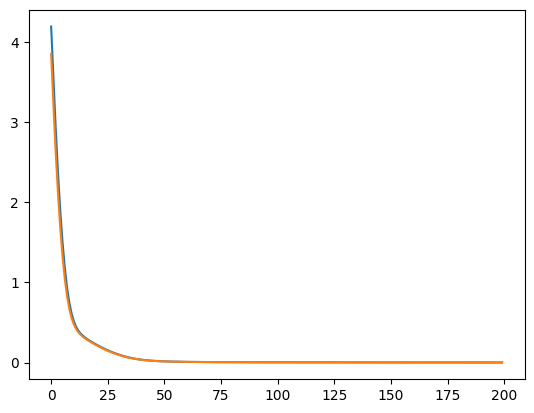

In [12]:
plt.plot(train_loss)
plt.plot(test_loss)

 ## 9. LSTM함수가 얼마나 잘 학습 되었는지 확인해 봅시다.
 
  - 초기값은 sin함수 1주기 후 마지막 5개 값으로 하고 
  
  - 이를 바탕으로 6번째 예측을 한 후 
  
  - 다시 새롭게 추가된 값으로부터 마지막 5개를 새로운 입력으로 하여
  
  - 3 주기를 반복해봅시다

torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size

/Users/ohbeomseok/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


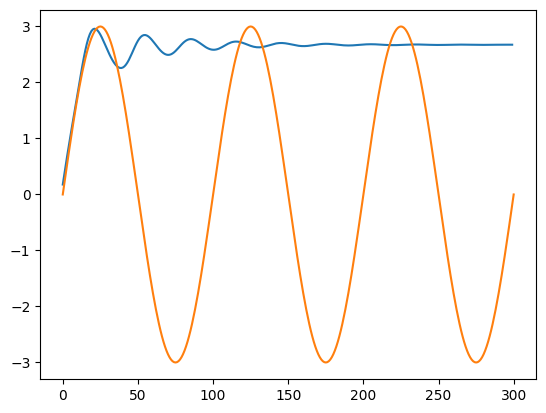

In [13]:
init_test = toy_problem(1,T, amp=3)
init_test = torch.tensor(init_test[-5:].reshape(1,5,1), dtype=torch.float).cpu()

h_state = torch.zeros(1,1,16).cpu()
c_0 = torch.zeros(1,1,16).cpu()
pred_length = 3

for i in range(T*pred_length):
    model = model.cpu()
    init_test = torch.tensor(init_test, dtype=torch.float).cpu()
    r = model(init_test[-5:].reshape(1,5,1), (h_state,c_0)).clone().detach().numpy()
    
    init_test = np.concatenate((init_test.clone().detach().numpy().squeeze(),r),axis=None)

    
plt.plot(init_test[5:])
print(2018125034)
plt.plot(toy_problem(pred_length,T,amp=3))

## 10. 잘 예측이 됩니까? 안된다면 이유가 무엇일까요? 사인함수의 예측에 LSTM 모델을 사용하는 것이 좋은 선택일까요?

정답) #채우시오

잘 되는 것 같으면서도 잘 안되는 것 같다. 사실 위의 그래프만 보면 잘 예측했다고 생각할 수 있지만, 위 그래프는 여러 번의 반복 끝에 나온 결과이다.<br>
항상 위 그래프처럼 예측이 잘되는 그래프가 나오는 것은 아니었다.<br>
사인함수의 예측에 LSTM 모델을 사용하는 것보다 오히려 저번 과제인 RNN 모델을 사용하는 것이 더 나은 것 같다. <br>
RNN 모델을 다시 여러번 실행 시켜보니 LSTM보다 RNN이 더 안정적으로 예측하는 것을 확인할 수 있었다.